In [1]:
import logging
import pandas as pd
import numpy as n
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


df = pd.read_csv('train.csv')


ALL Classes for Topic:
['Shipment and delivery' 'Not Effective' 'Customer Service' 'Allergic'
 'Texture' 'Quality/Contaminated' 'Color and texture' 'Bad Taste/Flavor'
 'Too big to swallow' 'Smells Bad' 'Too Sweet' 'Ingredients' 'Expiry'
 'Packaging' 'Wrong Product received' 'Pricing' 'False Advertisement'
 'Inferior to competitors' "Didn't Like" 'Customer Issues' 'Hard to Chew']
topic
Allergic                    567
Bad Taste/Flavor           1194
Color and texture           234
Customer Issues               8
Customer Service            239
Didn't Like                  31
Expiry                      136
False Advertisement          37
Hard to Chew                  6
Inferior to competitors      44
Ingredients                 216
Not Effective               611
Packaging                   467
Pricing                     107
Quality/Contaminated        715
Shipment and delivery       390
Smells Bad                  123
Texture                     410
Too Sweet                    97
Too 

TypeError: show() got an unexpected keyword argument 'rotation'

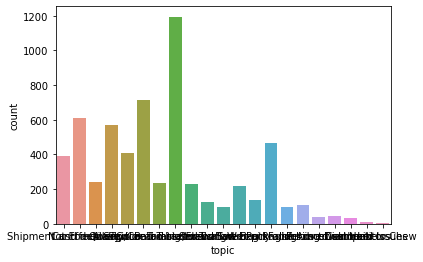

In [5]:
# Get the Total No of Different Topics

print('ALL Classes for Topic:')
print(df.topic.unique())

#Get Topic wise distribution

print(df.groupby('topic').size())

import seaborn as sns
sns.countplot(df['topic'],label="Count")
plt.show()

In [ ]:
''' Handle the Duplicate review texts across various topics and for the same Review Text and Review Title combination 
take the topic with least no of Texts.'''

'''
df_class_count = df.groupby(['topic'], as_index= False).agg({'Review Text':'count'})

df_class_count = df_class_count.rename(columns = {'Review Text':'NoOfReviews'})
df_class_count = df_class_count.sort_values(by = ['NoOfReviews'])


#print(df.columns)
#print(df_class_count.columns)

df2 = df.merge(df_class_count, on = ['topic'], how = 'left')
df2 = df2.sort_values(by = ['NoOfReviews'])

#print(df.head())

df2 = df2.drop_duplicates(['Review Text'])
'''

In [ ]:
# Removing the rows with duplicate Review Text

def fun(x):
    return len(set(list(x)))

df_rev_count = df.groupby(['Review Text'], as_index= False).agg({'topic':fun})

len(df_rev_count)
#print(df_rev_count.head())

df_rev_count = df_rev_count.rename(columns = {'topic':'NoOfTopics'})


dfx = df.merge(df_rev_count, on = ['Review Text'], how = 'left')
dfx = dfx[dfx['NoOfTopics'] == 1]

print(dfx.head())
len(df_rev_count)

df = dfx.copy()


In [ ]:
#Result after Removing messages having duplicate rows

#Get Topic wise distribution
print('ALL Classes for Topic:')
print(df.topic.unique())
print(len(df.topic.unique()))

print(df.groupby('topic').size())

import seaborn as sns
sns.countplot(df['topic'],label="Count")
plt.show()

In [ ]:
df['post'] = df['Review Title'] + ' ' + df['Review Text']
df['post'].apply(lambda x: len(x.split(' '))).sum()

#Data Cleaning
lemmatizer = WordNetLemmatizer()
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = ' '.join([w for w in text.split() if len(w)>2])
    #text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

def clean_text2(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = ' '.join([w for w in text.split() if len(w)>2])
    #text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return text
    

df['Review Text'] = df['Review Text'].apply(clean_text)
df['Review Title'] = df['Review Title'].apply(clean_text2)
#print(df.head(10))

df['post'] = df['Review Title'] + ' ' + df['Review Text']
df = df.rename(columns={'topic':'tags'})

df['post'].apply(lambda x: len(x.split(' '))).sum()

In [ ]:

X_train = pd.Series()
y_train = pd.Series()
X_test = pd.Series()
y_test = pd.Series()

all_class = df.tags.unique().tolist()

for cls in all_class:
    X_tmp = df[df['tags']==str(cls)]['post']
    y_tmp = df[df['tags']==str(cls)]['tags']
    #print(len(X_tmp))
    #print(len(y_tmp))
    train_X, test_X, train_Y, test_Y = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state = 42)
    X_train = X_train.append(train_X)
    X_test = X_test.append(test_X)
    y_train = y_train.append(train_Y)
    y_test = y_test.append(test_Y)
    
#print(len(X_train))
#print(type(X_train))


In [ ]:
print(X_train.head())
#print(len(X_test))
#print(len(y_train))
#print(len(y_test))


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

my_tags = df['tags'].unique().tolist()

print('accuracy %s', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=3, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

xboost = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgboost.XGBClassifier()),
               ])
xboost.fit(X_train, y_train)


y_pred = xboost.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:


import xgboost

'''xboost = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgboost.XGBClassifier(learning_rate =0.2, n_estimators=1000, max_depth=6, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'multi:softmax',num_class = 21, nthread=4, scale_pos_weight=1, seed=27)),
               ])'''

xboost2 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgboost.XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)),
               ])

xboost2.fit(X_train, y_train)

y_pred = xboost2.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))



In [ ]:
from sklearn.multiclass import OneVsRestClassifier

import xgboost

xboost3 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(xgboost.XGBClassifier())),
               ])
xboost3.fit(X_train, y_train)

y_pred = xboost3.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


In [ ]:
test_data = pd.read_csv('test.csv')

test_data['Review Text'] = test_data['Review Text'].apply(clean_text)
#print(df.head(10))

X_test_fin = test_data['Review Title'] + ' ' + test_data['Review Text']

X_train = df['post']
y_train = df['tags']


In [ ]:
len(X_train)

In [ ]:
#Final Run for Final Output for xgboost

import xgboost
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

xboost = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgboost.XGBClassifier()),
               ])
xboost.fit(X_train, y_train)

y_pred_final = xboost.predict(X_test_fin)
df_res = pd.DataFrame({'y_p':y_pred_final})

df_res.to_csv('Res_joined_xboost_new.csv',index=False)

In [ ]:
#Final Run for Final Output for Linear Model

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=3, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred_final = sgd.predict(X_test_fin)
df_res = pd.DataFrame({'y_p':y_pred_final})

df_res.to_csv('Res_joined_linear_n.csv',index=False)

In [ ]:
#Final Run for Final Output for Logistic Model

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

logreg.fit(X_train, y_train)

y_pred_final = logreg.predict(X_test_fin)
df_res = pd.DataFrame({'y_p':y_pred_final})

df_res.to_csv('Res_joined_logistic.csv',index=False)

In [ ]:
#Final Run for Final Output for xgboost with OneVsRestClassifier

from sklearn.multiclass import OneVsRestClassifier

import xgboost

xboost3 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(xgboost.XGBClassifier())),
               ])
xboost3.fit(X_train, y_train)


y_pred_final = xboost3.predict(X_test_fin)
df_res = pd.DataFrame({'y_p':y_pred_final})

df_res.to_csv('Res_joined_xboost_with_ORC.csv',index=False)